# Árbol de clasificación

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np

In [2]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='magma', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

In [3]:
base_df = pd.read_csv("data_bases/base_final.csv")

In [4]:
base_df.head(10)

,Unnamed: 0,index,num_caso,tiempo_adeudo,num_retrasos,comp_interno1,prest_aceptado
0,0,0.0,1,62.0,4.0,3039.513678,1
1,1,6.0,7,29.0,3.0,1547.112462,1
2,2,7.0,8,59.0,4.0,1215.805471,1
3,3,8.0,9,15.0,0.0,0.000000,1
4,4,9.0,10,16.0,1.0,0.000000,1
5,5,13.0,14,56.0,6.0,0.000000,1
6,6,17.0,18,58.0,6.0,0.000000,1
7,7,20.0,21,54.0,3.0,0.000000,1
8,8,21.0,22,26.0,2.0,1317.122594,1
9,9,23.0,24,4.0,0.0,0.000000,1


In [5]:
base_df.pop("index")

0        0.0
1        6.0
2        7.0
3        8.0
4        9.0
        ... 
49995    0.0
49996    0.0
49997    0.0
49998    0.0
49999    0.0
Name: index, Length: 50000, dtype: float64

In [6]:
base_df.pop("Unnamed: 0")

0            0
1            1
2            2
3            3
4            4
         ...  
49995    49995
49996    49996
49997    49997
49998    49998
49999    49999
Name: Unnamed: 0, Length: 50000, dtype: int64

In [7]:
base_df.head()

,num_caso,tiempo_adeudo,num_retrasos,comp_interno1,prest_aceptado
0,1,62.0,4.0,3039.513678,1
1,7,29.0,3.0,1547.112462,1
2,8,59.0,4.0,1215.805471,1
3,9,15.0,0.0,0.000000,1
4,10,16.0,1.0,0.000000,1


<AxesSubplot:xlabel='prest_aceptado', ylabel='count'>

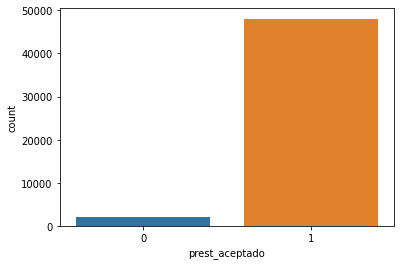

In [8]:
sns.countplot(data=base_df, x="prest_aceptado")

In [9]:
X = base_df.copy()
y = X.pop("prest_aceptado")

$\text{Creamos los train y test sets}$

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

### Lo siguiente es definir los Transformation Pipelines

In [11]:
num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

In [12]:
num_features

['num_caso', 'tiempo_adeudo', 'num_retrasos', 'comp_interno1']

In [13]:
cat_features # No hay varibales categoricas en nuestra base de datos

[]

In [14]:
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

In [15]:
# Pipeline para variables númericas
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [16]:
# Pipeline para variables categoricas
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, sparse=False,
                                        handle_unknown='error', drop='first'))])

## Realizamos las transformaciones

In [17]:
full_pipeline = ColumnTransformer(transformers=[
               ('numerical', num_pipeline, num_features),
               ('categorical', cat_pipeline, cat_features)],
               remainder='drop')

In [18]:
dec_tree = DecisionTreeClassifier(random_state=42)

In [19]:
tree_pipeline = Pipeline(steps=[('preprocessor', full_pipeline),('classifier', dec_tree)])

In [20]:
tree_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                       

## Confusion Matrix y ROC curve - Primer modelo

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'specificity': 1.0,
 'f1_score': 1.0,
 'cohens_kappa': 1.0,
 'roc_auc': 1.0,
 'pr_auc': 1.0}

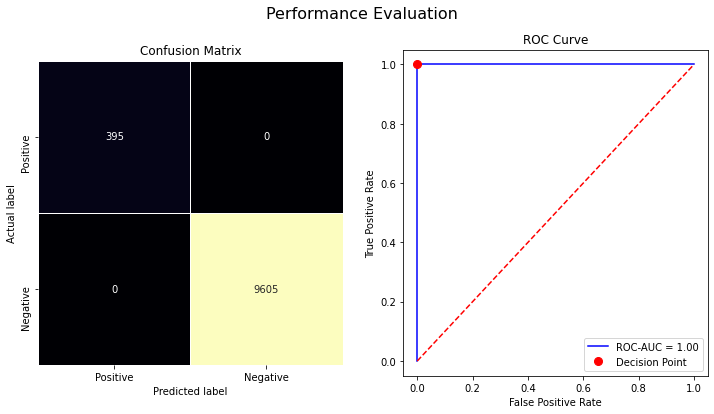

In [21]:
LABELS = ['Positive', 'Negative']
performance_evaluation_report(tree_pipeline, X_test,y_test, labels=LABELS,show_plot=True)

Como podemos observar este modelo al observar la curva $\textit{ROC}$ parece ser bueno, recordando que esta 
curva describe una relación entre la sensibilidad del modelo (la tasa de verdaderos positivos o TPR) contra su 
especificidad (descrita con respecto a la tasa de falsos positivos: 1-FPR), pero tal vez no sea lo demasiado robusto

En lo anterior como se vió en clase, aplicamos básicamente el tratamiento de los missings como un paso en el pipline, sin embargo, se pueden hacer muchas otras cosas, obviamente:

1.- Reescalamiento o estandarización de variables, esto es porque normalmente las variables no están en la misma escala, esto puede introducir sesgo en el modelo. Por ejemplo, para los modelos de regresión o K-vecinos, se recomienda considerar este paso. En general, los métodos basados en árboles de clasificación no requieren considerar el escalamiento. En scikit - learn algunas opciones populares son: StandardScaler y MinMaxScaler.

2.- Discretización de varibles continuas.

3.- Transformación eliminado Outliers: Durante el análisis exploratorio de Datos que se hizo en la Tarea 1, la base puede tener incosistencias. Este tipo de cuestiones, pueden sesgar el modelo y entonces debemos tratarlos de alguna manera, es lo que se recomienda.

En lo que sigue, eliminaremos los outiliers de la base de datos para tener un modelo más robusto. Crearemos una función que detecte y modifique los valores atípicos.

### Creamos nuestro propio transformador

In [22]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values


### Realizamos de nuevo el proceso anterior, pero usando un Pipeline que use nuestro Transformador

In [23]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())])

# Modificamos nuestro Pipeline para var númericas

In [24]:
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],
                                 remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

In [25]:
tree_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                       

## Confusion Matrix y ROC curve - Segundo modelo

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'specificity': 1.0,
 'f1_score': 1.0,
 'cohens_kappa': 1.0,
 'roc_auc': 1.0,
 'pr_auc': 1.0}

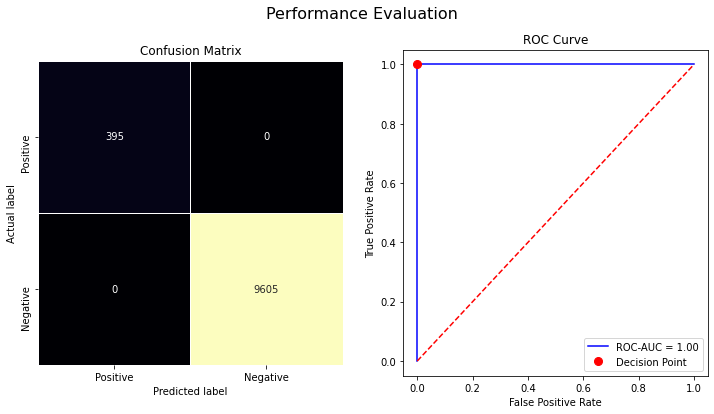

In [26]:
performance_evaluation_report(tree_pipeline, X_test, y_test, labels=LABELS, show_plot=True)

Sin embargo nos queda un modelo igual al anterior

## Realizamos Cross Validation

In [27]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [28]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([1.      , 1.      , 1.      , 1.      , 0.999875])

In [29]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

{'fit_time': array([0.055161  , 0.03353214, 0.03611922, 0.0311172 , 0.03313899]),
 'score_time': array([0.0196259 , 0.01637101, 0.01728129, 0.01624727, 0.01591682]),
 'test_accuracy': array([1.      , 1.      , 1.      , 1.      , 0.999875]),
 'test_precision': array([1.        , 1.        , 1.        , 1.        , 0.99986988]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([1.        , 1.        , 1.        , 1.        , 0.99841772])}

In [30]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 11),
               'classifier__min_samples_leaf': range(2, 11)}

In [31]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   17.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                           

### Vemos cuales son los mejores parametros

In [32]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2}
Recall (Training set): 1.0000
Recall (Test set): 1.0000


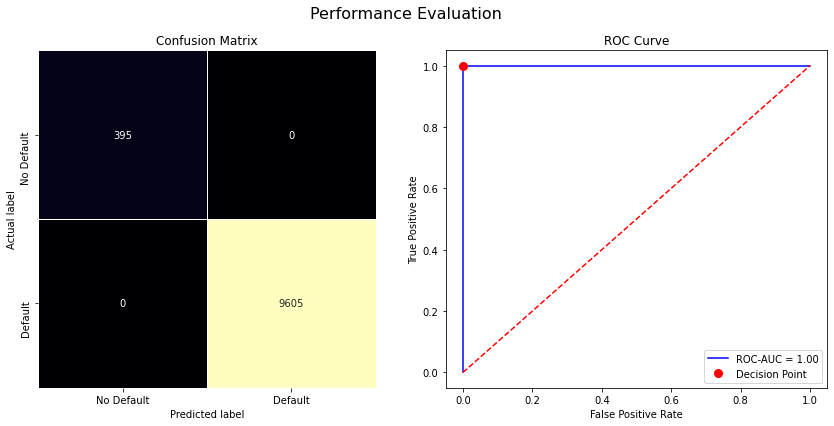

In [33]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
#plt.savefig('images/ch8_im20.png')
plt.show()